# 20CRv3 superposed epoch analysis
This notebook analyses global and Australian monthly temperature and precipitation anomalies in the decade surrounding the five major volcanic eruptions since 1850 - Krakatau 1883, Santa Maria 1902, Agung 1963, El Chicon 1982, Pinatubo 1991 - using 20CRv3 reanalysis data (79 ensemble members).    
It then overlays the time series for each volcanic eruption, takes the average across the volcanic eruptions and plots the results. 

In [3]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import dask.diagnostics
import scipy

In [4]:
path = '/g/data/w40/W48_GDATA_MOVED/kb6999/'

In [5]:
# import custom functions
import sys 
sys.path.append(f'{path}/Masters_paper') 
import GRL_functions as func

In [6]:
# create a list of member names excluding member 70 cos that file is problematic 
members = [*range(1,70),*range(71,81)]

In [7]:
# read in raw 20CR temperature data
tmp_paths = [f"{path}/Reanalysis/20CR_TMP_raw_members/R_raw_Glob_TMP{m:02d}.nc" for m in members]
ds_tmp = xr.open_mfdataset(tmp_paths, combine='nested', concat_dim='member', chunks={'time': 100})
ds_tmp.coords['member'] = members

In [8]:
# read in raw 20CR precipitation data
pr_paths = [f"{path}/Reanalysis/20CR_PRATE_raw_members/R_raw_Glob_PRATE{m:02d}.nc" for m in members]
ds_pr = xr.open_mfdataset(pr_paths, combine='nested', concat_dim='member', chunks={'time': 100})
ds_pr.coords['member'] = members

In [10]:
# combine tmp and pr into one dataset
reanal_r = xr.Dataset({'tmp': ds_tmp.TMP, 'pr': ds_pr.PRATE})
# convert into degrees Celsius
reanal_r['tmp'] = reanal_r.tmp-273

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/array/core.py:4828: PerformanceWarning: Increasing number of chunks by factor of 20
  result = blockwise(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/array/core.py:4828: PerformanceWarning: Increasing number of chunks by factor of 20
  result = blockwise(


In [11]:
# reverse the latitude axis so it goes from -90 to 90
reanal = reanal_r.reindex(lat=list(reversed(reanal_r.lat)))

In [12]:
# area weighting 
reanal_w = reanal_r*np.cos(reanal_r.lat*(np.pi/180))

### Eruption dates

In [13]:
# define an array of eruption names
volcanoes = ['Krakatau', 'Santa Maria','Agung','El Chichon', 'Pinatubo']

In [14]:
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])

eruptions = {v: d for v, d in zip(volcanoes, e_date)}
eruptions

{'Krakatau': Timestamp('1883-08-01 00:00:00'),
 'Santa Maria': Timestamp('1902-10-01 00:00:00'),
 'Agung': Timestamp('1963-03-01 00:00:00'),
 'El Chichon': Timestamp('1982-04-01 00:00:00'),
 'Pinatubo': Timestamp('1991-06-01 00:00:00')}

In [15]:
# save arrays of times relative to each eruption
e_pre5yrs = e_date - 60 * pd.offsets.MonthBegin()
e_pre3mon = e_date - 3 * pd.offsets.MonthBegin()
e_post5yrs = e_date + 61 * pd.offsets.MonthBegin()

In [16]:
# select out the 10 year time frame around each eruption (5yrs before and after)
Krakatau = reanal_w.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
SantaMaria = reanal_w.sel(time = slice(e_pre5yrs[1], e_post5yrs[1]))
Agung = reanal_w.sel(time = slice(e_pre5yrs[2], e_post5yrs[2]))
ElChicon = reanal_w.sel(time = slice(e_pre5yrs[3], e_post5yrs[3]))
Pinatubo = reanal_w.sel(time = slice(e_pre5yrs[4], e_post5yrs[4]))

### Anomalies

In [17]:
# use functions to calculate the monthly anomalies for the globe
K_mon_anom_Glob = func.monthly_anomaly(Krakatau, e_pre5yrs[0], e_pre3mon[0])
S_mon_anom_Glob = func.monthly_anomaly(SantaMaria, e_pre5yrs[1], e_pre3mon[1])
A_mon_anom_Glob = func.monthly_anomaly(Agung, e_pre5yrs[2], e_pre3mon[2])
E_mon_anom_Glob = func.monthly_anomaly(ElChicon, e_pre5yrs[3], e_pre3mon[3])
P_mon_anom_Glob = func.monthly_anomaly(Pinatubo, e_pre5yrs[4], e_pre3mon[4])

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/

In [18]:
times = np.arange(-60,61)
# reset all the times so 0 corresponds to the eruption year and month
K_mon_anom_Glob['time'] = times
S_mon_anom_Glob['time'] = times
A_mon_anom_Glob['time'] = times
E_mon_anom_Glob['time'] = times 
P_mon_anom_Glob['time'] = times

# delete the months dimension (but not the time)
if 'month' in P_mon_anom_Glob:
    del K_mon_anom_Glob['month']
    del S_mon_anom_Glob['month']
    del A_mon_anom_Glob['month']
    del E_mon_anom_Glob['month']
    del P_mon_anom_Glob['month']

### Landmask

In [19]:
# import landmask dataset for temperaure
landfrac_tmp = xr.open_dataset(f'{path}/Reanalysis/20CR_data_netcdfs/land_20CR.nc')
landmask = landfrac_tmp
# and for precipitation
landfrac_pr = xr.open_dataset(f'{path}/Reanalysis/20CR_data_netcdfs/land_pr_20CR.nc')
landmask_pr = landfrac_pr

In [20]:
# select out each Australia region for each volcano for temperature
K_mon_Aus_tmp = K_mon_anom_Glob.tmp.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask.LAND==1, drop=True)
S_mon_Aus_tmp = S_mon_anom_Glob.tmp.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask.LAND==1, drop=True)
A_mon_Aus_tmp = A_mon_anom_Glob.tmp.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask.LAND==1, drop=True)
E_mon_Aus_tmp = E_mon_anom_Glob.tmp.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask.LAND==1, drop=True)
P_mon_Aus_tmp = P_mon_anom_Glob.tmp.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask.LAND==1, drop=True)

In [21]:
# select out each Australia region for each volcano for temperature
K_mon_Aus_pr = K_mon_anom_Glob.pr.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask_pr.LAND==1, drop=True)
S_mon_Aus_pr = S_mon_anom_Glob.pr.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask_pr.LAND==1, drop=True)
A_mon_Aus_pr = A_mon_anom_Glob.pr.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask_pr.LAND==1, drop=True)
E_mon_Aus_pr = E_mon_anom_Glob.pr.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask_pr.LAND==1, drop=True)
P_mon_Aus_pr = P_mon_anom_Glob.pr.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask_pr.LAND==1, drop=True)

In [22]:
# combine variables again
K_mon_Aus = xr.Dataset({'tmp': K_mon_Aus_tmp, 'pr': K_mon_Aus_pr})
S_mon_Aus = xr.Dataset({'tmp': S_mon_Aus_tmp, 'pr': S_mon_Aus_pr})
A_mon_Aus = xr.Dataset({'tmp': A_mon_Aus_tmp, 'pr': A_mon_Aus_pr})
E_mon_Aus = xr.Dataset({'tmp': E_mon_Aus_tmp, 'pr': E_mon_Aus_pr})
P_mon_Aus = xr.Dataset({'tmp': P_mon_Aus_tmp, 'pr': P_mon_Aus_pr})

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/array/core.py:4828: PerformanceWarning: Increasing number of chunks by factor of 79
  result = blockwise(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/array/core.py:4828: PerformanceWarning: Increasing number of chunks by factor of 79
  result = blockwise(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/array/core.py:4828: PerformanceWarning: Increasing number of chunks by factor of 79
  result = blockwise(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/array/core.py:4828: PerformanceWarning: Increasing number of chunks by factor of 79
  result = blockwise(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/dask/array/core.py:4828: PerformanceWarning: Increasing number of chunks by factor of 79
  result = blockwise(
/g/data/hh5/public/apps/m

In [23]:
# calculate the monthly model mean for global monthly anomalies
K_llm_Glob = K_mon_anom_Glob.mean(dim=('lat','lon'))
S_llm_Glob = S_mon_anom_Glob.mean(dim=('lat','lon'))
A_llm_Glob = A_mon_anom_Glob.mean(dim=('lat','lon'))
E_llm_Glob = E_mon_anom_Glob.mean(dim=('lat','lon'))
P_llm_Glob = P_mon_anom_Glob.mean(dim=('lat','lon'))

In [24]:
# calculate the monthly model mean for Australian monthly anomalies
K_llm_Aus = K_mon_Aus.mean(dim=('lat','lon'))
S_llm_Aus = S_mon_Aus.mean(dim=('lat','lon'))
A_llm_Aus = A_mon_Aus.mean(dim=('lat','lon'))
E_llm_Aus = E_mon_Aus.mean(dim=('lat','lon'))
P_llm_Aus = P_mon_Aus.mean(dim=('lat','lon'))

### Combine eruptions

In [25]:
# Combine data for all eruptions into one array
composite_llm_Glob = func.SEA_combine(K_llm_Glob, S_llm_Glob, A_llm_Glob, E_llm_Glob, P_llm_Glob, volcanoes)
composite_llm_Aus = func.SEA_combine(K_llm_Aus, S_llm_Aus, A_llm_Aus, E_llm_Aus, P_llm_Aus, volcanoes)

In [ ]:
# save the composties off as a net cdf
composite_llm_Glob.to_netcdf(f'{path}/Reanalysis/20CR_SEA_data_for_plots/_composite_llm_Glob.nc')
composite_llm_Aus.to_netcdf(f'{path}/Reanalysis/20CR_SEA_data_for_plots/_composite_llm_Aus.nc')

In [27]:
# open composite files of all volcanoes
composite_llm_Glob = xr.open_dataset(f'{path}/Reanalysis/20CR_SEA_data_for_plots/_composite_llm_Glob.nc')
composite_llm_Aus = xr.open_dataset(f'{path}/Reanalysis/20CR_SEA_data_for_plots/_composite_llm_Aus.nc')

In [28]:
#rename krakatoa to Krakatau in the Aust array
composite_llm_Glob['volcano'] = ['Krakatau', 'Santa Maria', 'Agung', 'El Chichon', 'Pinatubo']
composite_llm_Aus['volcano'] = ['Krakatau', 'Santa Maria', 'Agung', 'El Chichon', 'Pinatubo']

Right now I have all the models stored in one array so from hereafter I can calculate anomalies etc.  
## Select out regions and eruption dates

In [29]:
# take the multi member mean
composite_mmm_Glob = composite_llm_Glob.mean(dim='member')
composite_mmm_Aus = composite_llm_Aus.mean(dim='member')

In [30]:
# rolling mean
composite_mmm_Glob_roll12 = composite_mmm_Glob.rolling(time=12).mean()
composite_mmm_Aus_roll12 = composite_mmm_Aus.rolling(time=12).mean()

In [31]:
# take the composite over all volcanoes
V_composite_mmm_Glob = composite_mmm_Glob.mean(dim='volcano')
V_composite_mmm_Aus = composite_mmm_Aus.mean(dim='volcano')

In [32]:
# rolling mean
V_composite_mmm_Glob_roll12 = V_composite_mmm_Glob.rolling(time=12).mean()
V_composite_mmm_Aus_roll12 = V_composite_mmm_Aus.rolling(time=12).mean()

In [33]:
# calculate the percentiles and then take the mean along the model dimension for monthly anomalies
p10_Glob = composite_llm_Glob.chunk({'member': -1,'volcano': -1}).quantile(0.1, dim=['member', 'volcano'])
p10_Aus = composite_llm_Aus.chunk({'member': -1,'volcano': -1}).quantile(0.1, dim=['member', 'volcano'])

p90_Glob = composite_llm_Glob.chunk({'member': -1,'volcano': -1}).quantile(0.9, dim=['member', 'volcano'])
p90_Aus = composite_llm_Aus.chunk({'member': -1,'volcano': -1}).quantile(0.9, dim=['member', 'volcano'])

In [34]:
# rolling mean
p10_Glob_roll12 = p10_Glob.rolling(time=12).mean()
p10_Aus_roll12 = p10_Aus.rolling(time=12).mean()

p90_Glob_roll12 = p90_Glob.rolling(time=12).mean()
p90_Aus_roll12 = p90_Aus.rolling(time=12).mean()

# Figures

In [35]:
# set the default font size
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [36]:
# create custom colour groups for plots
reds = ['crimson', 'maroon', 'orangered', 'orange', 'pink']
greens = ['darkgreen','lime','#68CB61', 'olivedrab', '#E5FCDA']

In [37]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

### Australia

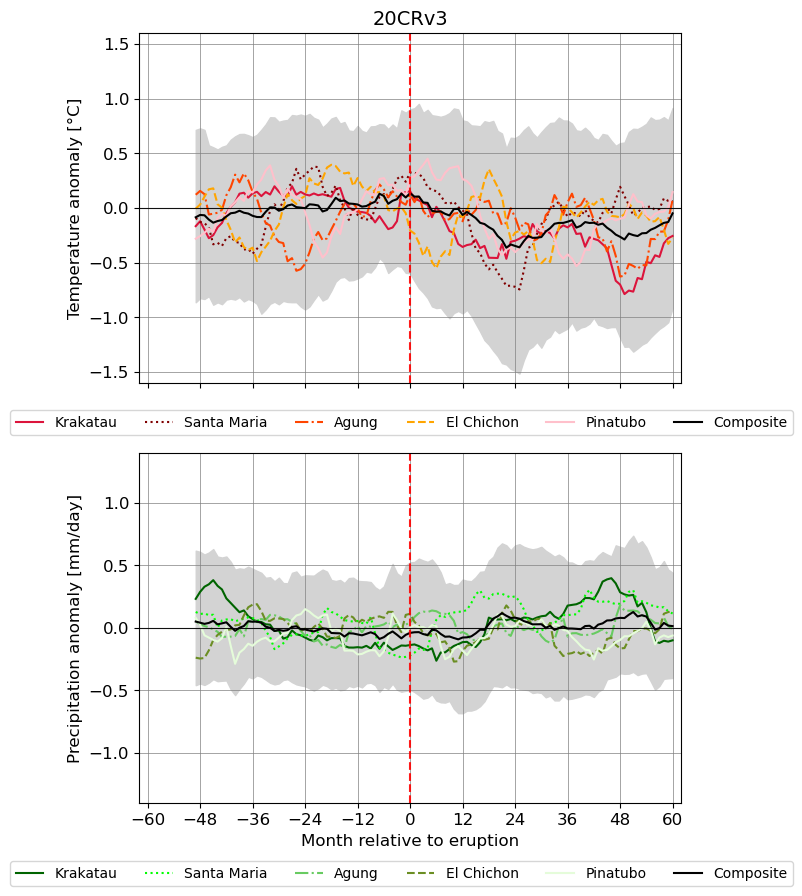

In [38]:
# plot monthly anomalies of temperature as a superposed epoch analysis of all 5 eruptions plus composite
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(7,10))

# make subplots for each region
func.SEA_plots(composite_mmm_Aus_roll12.tmp, V_composite_mmm_Aus_roll12.tmp, p10_Aus_roll12.tmp, p90_Aus_roll12.tmp,
                reds, ax = axes[0])
func.SEA_plots(composite_mmm_Aus_roll12.pr, V_composite_mmm_Aus_roll12.pr, p10_Aus_roll12.pr, p90_Aus_roll12.pr, 
                greens, ax = axes[1])

# set axis labels and subplot titles
axes[0].set(ylabel = f'Temperature anomaly [{deg}C]', title = '20CRv3') 
axes[1].set(xlabel = 'Month relative to eruption', ylabel = f'Precipitation anomaly [mm/day]')

# remove minor gridlines 
axes[0].minorticks_off()
axes[1].minorticks_off()
# set axis limits 
axes[0].set_xlim(-62, 62)
axes[1].set_xlim(-62, 62)
axes[0].set_ylim(-1.6, 1.6)
axes[1].set_ylim(-1.4, 1.4)

# set legends
handles_t, labels_t = axes[0].get_legend_handles_labels()
handles_p, labels_p = axes[1].get_legend_handles_labels()

# create legend (first arg to bbox is x, second is y)
fig.legend(handles_t, labels_t, loc='upper center', bbox_to_anchor=(0.5, 0.51), ncol=6) 
fig.legend(handles_p, labels_p, loc='lower center', bbox_to_anchor=(0.5, 0.02), ncol=6) 

### Global

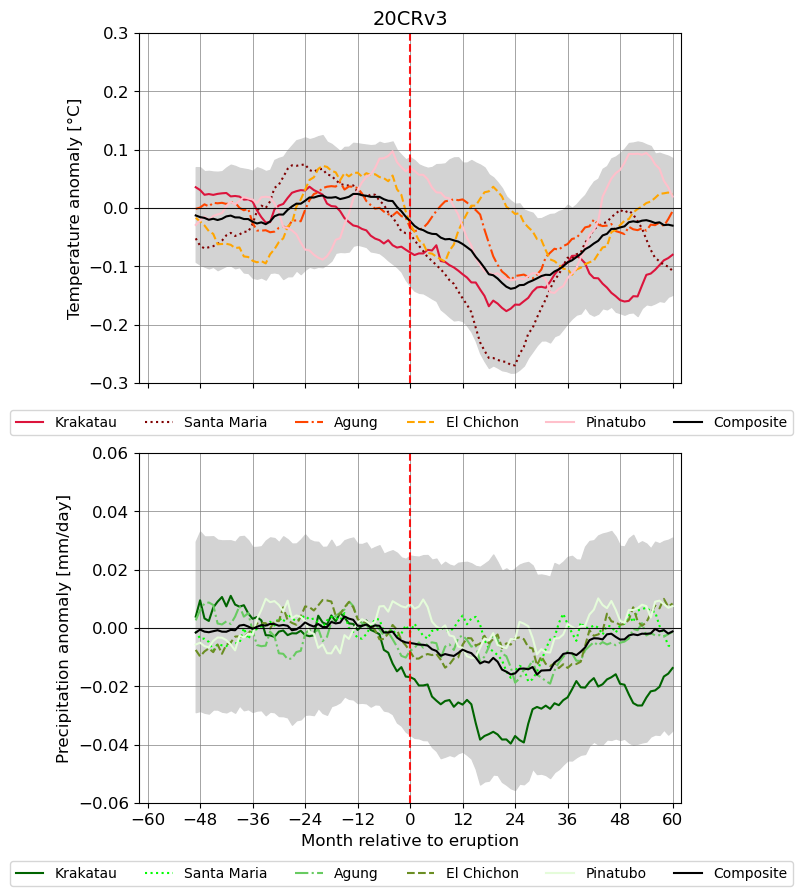

In [39]:
# plot monthly anomalies of temperature as a superposed epoch analysis of all 5 eruptions plus composite
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(7,10))

# make subplots for each region
func.SEA_plots(composite_mmm_Glob_roll12.tmp, V_composite_mmm_Glob_roll12.tmp, p10_Glob_roll12.tmp, 
                p90_Glob_roll12.tmp, reds, ax = axes[0])
func.SEA_plots(composite_mmm_Glob_roll12.pr, V_composite_mmm_Glob_roll12.pr, p10_Glob_roll12.pr, p90_Glob_roll12.pr, 
                greens, ax = axes[1])

# set axis labels and subplot titles
axes[0].set(ylabel = f'Temperature anomaly [{deg}C]', title = '20CRv3') 
axes[1].set(xlabel = 'Month relative to eruption', ylabel = f'Precipitation anomaly [mm/day]')

# remove minor gridlines 
axes[0].minorticks_off()
axes[1].minorticks_off()
# set axis limits 
axes[0].set_xlim(-62, 62)
axes[1].set_xlim(-62, 62)
axes[0].set_ylim(-0.3, 0.3)
axes[1].set_ylim(-0.06, 0.06)

# set legends
handles_t, labels_t = axes[0].get_legend_handles_labels()
handles_p, labels_p = axes[1].get_legend_handles_labels()

# create legend (first arg to bbox is x, second is y)
fig.legend(handles_t, labels_t, loc='upper center', bbox_to_anchor=(0.5, 0.51), ncol=6) 
fig.legend(handles_p, labels_p, loc='lower center', bbox_to_anchor=(0.5, 0.02), ncol=6) 